In [1]:
import numpy as np
from typing import Tuple, Dict
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint
from einops import rearrange, repeat
from ToApps.to_apps import to_slack
import tensorflow as tf
from tensorflow.math import logical_not
from ktfuncs import kt_transformer
from builderfuncs import restore_model, EarlyStopAndSave
import keras_tuner as kt


df = pd.read_csv('data/scaled_U2_data.csv', index_col=0)
df.drop("UNNAMED: 0", axis=1, inplace=True)

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

print("Num GPUs Available: ", len(devices))

Num GPUs Available:  1


## Data Prep Functions

>#### ttv_split
> Splits the data into training, validation and testing data based on the floats passed to it. train_split, val_split, and test_split should add to 1.

> #### mask_window
> applies a mask over the decoder label inputs for single step prediction training

> #### split_window
> splits the data into encoder_inputs, decoder_inputs, decoder_labels, and labels

In [2]:
def ttv_split(ds: tf.data.Dataset, ds_size: int, 
              train_split: float = 0.8, 
              val_split: float = 0.1, 
              test_split: float = 0.1) -> Tuple[tf.data.Dataset, 
                                                tf.data.Dataset, 
                                                tf.data.Dataset]:

    assert (train_split + test_split + val_split) == 1
   
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


def mask_window(features: Tuple[Dict[tf.Tensor, tf.Tensor], tf.Tensor], 
                mask: tf.Tensor) -> Tuple[Dict[tf.Tensor, tf.Tensor], 
                                          tf.Tensor]:
    inputs = features[0]
    labels = features[1]
    decoder_labels = tf.einsum('tf,t->tf', labels, mask)
    mask = repeat(mask, 'i -> 1 i j', j=labels.shape[-2])
    mask = tf.math.minimum(mask, rearrange(mask, '1 i j -> 1 j i'))
    decoder_labels.set_shape([12, None])
    mask.set_shape([None, 12, 12])
    inputs.update({'decoder_labels':decoder_labels,
                   'attention_mask':mask})
    return inputs, labels


def split_window(features: tf.Tensor) -> Tuple[Dict[tf.Tensor, tf.Tensor],
                                               tf.Tensor]:
    encoder_input = features[:12, 1:]
    decoder_input = features[11:, 1:75]
    labels = rearrange(features[11:, 0], 'a -> a 1')
    encoder_input.set_shape([12, 247])
    decoder_input.set_shape([12, 74])
    labels.set_shape([12, None])
    

    return {'encoder_inputs':encoder_input, 'decoder_inputs':decoder_input}, labels

                        
def make_dataset(data: pd.DataFrame, length: int, 
                 batch_size: int = 64, multistep: bool = True) -> Tuple[tf.data.Dataset, 
                                                                        tf.data.Dataset, 
                                                                        tf.data.Dataset]:
    data = np.array(data.iloc[:, :], dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(data=data,
                                                        targets=None,
                                                        sequence_length=length,
                                                        sequence_stride=1,
                                                        shuffle=True,
                                                        seed=1,
                                                        batch_size=None)

    ds = ds.filter(lambda x: tf.reduce_all(logical_not(tf.math.is_nan(x))))
    ds = ds.map(split_window)
    if multistep == True:
        nums = np.zeros(170680)
    else:
        nums = np.random.randint(0, length/2-1, 170680)
    mask = tf.sequence_mask(nums, length/2, dtype=tf.float32)
    maskds = tf.data.Dataset.from_tensor_slices(mask)
    ds = tf.data.Dataset.zip((ds, maskds))
    ds = ds.map(mask_window).batch(batch_size)
    ds = ds.apply(tf.data.experimental.assert_cardinality(170680//batch_size + 1))
    train_ds, val_ds, test_ds = ttv_split(ds, 170680//batch_size, train_split=0.8, val_split=0.1, test_split=0.1)
    train_ds = train_ds
    return train_ds, val_ds, test_ds

In [3]:
import os
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
# train_print_callback = tf.keras.callbacks.LambdaCallback(on_train_begin=lambda logs: to_slack(f'{logs}'), 
#                                                          on_train_end=lambda logs: to_slack(f'{logs}'))

filepath = "best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
train_data, val_data, test_data = make_dataset(df, 23, batch_size=64)

In [4]:
from builderfuncs import save_whole_model
from keras_tuner.engine import tuner_utils
import GPUtil
gpu = GPUtil.getGPUs()[0]
from time import sleep
from ToApps.to_apps import to_slack

def _build_and_fit_model(self, trial, *args, **kwargs):
    """For AutoKeras to override.
    DO NOT REMOVE this function. AutoKeras overrides the function to tune
    tf.data preprocessing pipelines, preprocess the dataset to obtain
    the input shape before building the model, adapt preprocessing layers,
    and tune other fit_args and fit_kwargs.
    Args:
        trial: A `Trial` instance that contains the information needed to
            run this trial. `Hyperparameters` can be accessed via
            `trial.hyperparameters`.
        *args: Positional arguments passed by `search`.
        **kwargs: Keyword arguments passed by `search`.
    Returns:
        The fit history.
    """
    
    
    string = f"Transformer_trial_{trial.trial_id}\n"
    string += "------------------------------------------------\n"
    if trial.hyperparameters.values:
            for hp, value in trial.hyperparameters.values.items():
                string += f"{hp}: {value}\n"
    
    hp = trial.hyperparameters
    model = self._try_build(hp)
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
    tuner_utils.validate_trial_results(
        results, self.oracle.objective, "HyperModel.fit()"
    )
    try:
        path = os.path.join("transformerdir", f"trial_{trial.trial_id}")
        os.mkdir(path) 
    except FileExistsError:
         pass
    save_whole_model(model, f"transformerdir/trial_{trial.trial_id}")

    string += "------------------------------------------------\n"
    result_dict = tuner_utils.convert_to_metrics_dict(results, self.oracle.objective)
    string += f"loss: {result_dict['loss']:.6f}, r2: {result_dict['r2']:.6f}\n"
    string += f"val_loss: {result_dict['val_loss']:.6f}, val_r2: {result_dict['val_r2']:.6f}\n"
             
    string += "------------------------------------------------\n"
    while GPUtil.getGPUs()[0].temperature > 89.0:
        to_slack(str(GPUtil.getGPUs()[0].temperature))
        sleep(10)
    try:
        to_slack(string)
    except:
         print("cannot connect to slack")
    
    return results


In [5]:
import types
tuner = kt.BayesianOptimization(kt_transformer,
                                objective=kt.Objective('val_loss', 'min'),
                                max_trials=200,
                                directory='directory',
                                project_name="transformer_trial_1",
                                seed=1)
tuner._build_and_fit_model = types.MethodType(_build_and_fit_model, tuner)

INFO:tensorflow:Reloading Tuner from directory\transformer_trial_1\tuner0.json


In [6]:
tuner.search_space_summary()

Search space summary
Default search space size: 20
num_heads (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 16, 'step': 2, 'sampling': 'linear'}
lookback (Fixed)
{'conditions': [], 'value': 12}
n_features (Fixed)
{'conditions': [], 'value': 247}
n_manips (Fixed)
{'conditions': [], 'value': 74}
n_targs (Fixed)
{'conditions': [], 'value': 1}
horizon (Fixed)
{'conditions': [], 'value': 12}
ff_dim (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 16, 'step': 4, 'sampling': 'linear'}
ff_activ (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'elu', 'selu', 'gelu', 'sigmoid', 'tanh'], 'ordered': False}
num_encoders (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
num_decoders (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
mlp_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4

In [7]:
import traceback
try:
    tuner.search(train_data,
                epochs=25,
                verbose=2,
                validation_data=val_data,
                callbacks=[EarlyStopAndSave(filepath="model_folder", patience=3, quickstop="val_r2")])
except:
    # printing stack trace
    for i in range(5):
        to_slack("TRANSFORMER ERROR")
    traceback.print_exc()

Trial 200 Complete [00h 22m 36s]
val_loss: 0.013428912498056889

Best val_loss So Far: 0.0013977903872728348
Total elapsed time: 3d 14h 38m 15s
INFO:tensorflow:Oracle triggered exit


In [26]:
import json
hyperparams = []
for i in range(200):
    try:
        with open(f"directory/transformer_trial_1/trial_{i:03}/trial.json") as f:
            parameters = json.load(f)
        hyperparams.append(parameters)
    except FileNotFoundError:
        print(f"trial_{i:03} not found")

In [27]:
i = 0
while i < len(hyperparams):
    if hyperparams[i]["score"] == None:
        hyperparams.pop(i)
        print(i)
    else:
        i += 1

In [28]:
hyperparams = sorted(hyperparams, key=lambda x: x["score"])

In [29]:
table = []
from tabulate import tabulate
for i in range(25):
    line = [hyperparams[i]['trial_id']]
    for key in list(hyperparams[i]['hyperparameters']['values'].keys()):
        line.append(hyperparams[i]['hyperparameters']['values'][key])
    line.append(hyperparams[i]['score'])
    table.append(line)
headers = list(hyperparams[i]['hyperparameters']['values'].keys())
headers.append('score')
print(tabulate(table, headers=headers))


       num_heads    lookback    n_features    n_manips    n_targs    horizon    ff_dim  ff_activ      num_encoders    num_decoders    mlp_layers    mlp_units  mlp_activ      mlp_dropout    dropout  out_activ      learning_rate    beta_1    beta_2    epsilon       score
---  -----------  ----------  ------------  ----------  ---------  ---------  --------  ----------  --------------  --------------  ------------  -----------  -----------  -------------  ---------  -----------  ---------------  --------  --------  ---------  ----------
189           10          12           247          74          1         12        16  gelu                     2               4             1          128  relu                   0.1        0.1  linear                0.0001      0.85     0.991      1e-07  0.00139779
126           14          12           247          74          1         12        12  gelu                     1               4             4          256  gelu                   0.1     

In [31]:
model = restore_model('transformerdir/trial_189')

In [33]:
print(model.evaluate(test_data))

269/269 [==============================] - 29s 34ms/step - loss: 0.0011 - r2: 0.9764
[0.001076683052815497, 0.9763739705085754]


In [34]:
import matplotlib.pyplot as plt
test = test_data.unbatch().batch(1)
preds = model.predict(test)


17208/17208 [==============================] - 355s 20ms/step


In [35]:
iterator = test.as_numpy_iterator()
elements = [element for element in iterator]

In [36]:
print(elements[1][1])
print(len(elements))

[[[0.663]
  [0.678]
  [0.619]
  [0.619]
  [0.619]
  [0.65]
  [0.643]
  [0.603]
  [0.625]
  [0.627]
  [0.629]
  [0.631]]]
17208


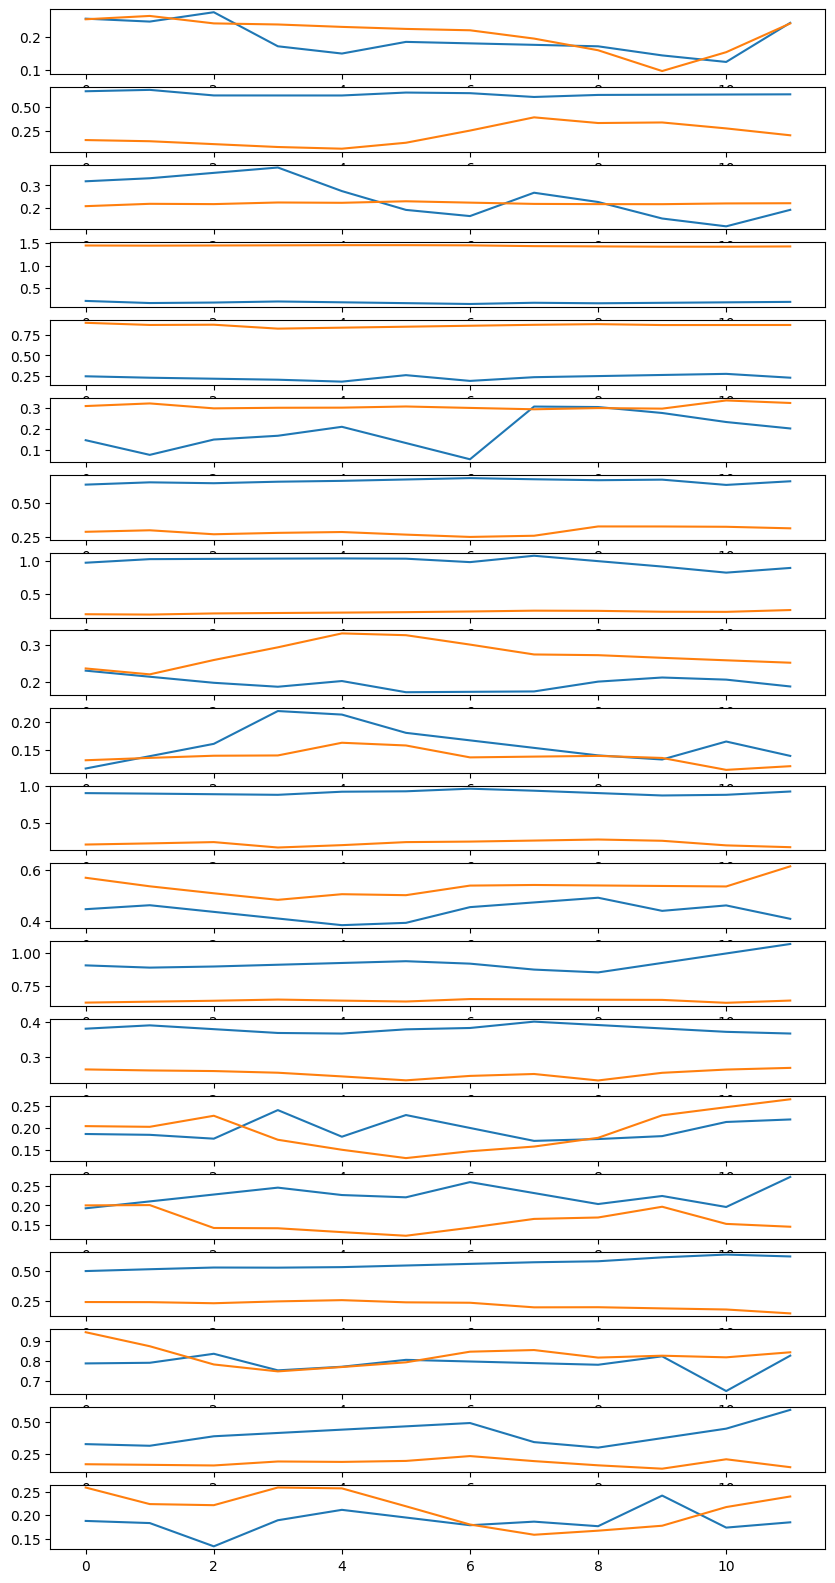

In [37]:
fig, ax = plt.subplots(20, figsize=(10, 20))
for i in range(20):
    ax[i].plot(elements[i][1][0, :, 0])
    ax[i].plot(preds[i])